In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, autojit, prange
from scipy.ndimage.filters import convolve
from skimage.transform import rotate
import matplotlib.patches as mpatches
# Disable inline plots
#%matplotlib qt

In [9]:
# Sn estimator described in doi:10.2307/2291267 (https://www.tandfonline.com/doi/abs/10.1080/01621459.1993.10476408)
# Efficiency of 58% for a gaussian distribution
# Does not impose symmetry on distribution
# Input some data set
@jit
def s_est(data):
    data = np.ndarray.flatten(data) # Collapse data into 1D
    c = 1.1926 # Constant 
    q = [] # List for differences between values
    length = len(data)
    
    for i in range (0, length):
        q.append(np.median(np.abs(np.subtract(data[i], data)))) # Compute median of absolute differences between each element
        
    r = np.median(q) # Compute median of (medians of absolute differences)
    return np.multiply(c, r)

# Does a 1D ft, doesn't need to be rolled over
@jit
def ft(signal):
    return np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(signal)))
# Fourier transform 2D slices of an image
@jit
def ft_slices(data):
    shape = np.shape(data) # Get shape of input data
    fslices = np.zeros(shape, dtype = np.complex_) # Array of complex zeros with same shape as input data
    l1 = shape[0] # Number of 2D slices through 3D volume
    for i in range (0, l1):
        fslices[i] = ft(data[i]) # Assign FT of individual slices to corresponding slice in zero array
        #print(i, end = ' ') # Testing counter printout
    return fslices
# Take FT of columns through 2D slices
@jit
def ft_columns(data):
    shape = np.shape(data) # Get shape of input data
    out = np.zeros(shape, dtype = np.complex_) # Array of complex zeros with same shape as input data
    l1 = shape[0] # Total number of loops for y dim
    l2 = shape[1] # Total number of loops for z dim
    for i in range (0, l1): # Loop through y
        for j in range (0, l2): # Loop through z
            out[:, i, j] = ft(data[:, i, j]) # Assign FT through x axis to corresponding region of zero array
        #print (i, end = ' ') # Testing counter printout
    return out
# Take 3D FT by taking FT of 2D slices through an image and then 1D columns perpendicular to slices
@jit
def ft_3d(data):
    slices = ft_slices(data)
    cols = ft_columns(slices)
    return cols
# Generates a gaussian window centered in the image with given input sigma
# Pixels in image are mapped from -2 to 2
# Does not drop off to 0 at edges, maybe fix, probably doesn't actually matter
def gauss_win_3d(width, sigma):
    rng = 2
    x, y, z = np.meshgrid(np.linspace(-rng,rng,width), np.linspace(-rng,rng,width), np.linspace(-rng,rng,width))
    d = np.sqrt(x*x+y*y+z*z) # generate matrix of distances
    mu = 0 # Make gaussian centered in image
    g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) ) # Map gaussian over distance matrix
    #cent = np.int(np.ceil(width/2)) # Get center row 
    #minval = np.min(g[cent]) # Get minimum value from center row of image
    #g = np.subtract(g, minval) # Subtract minimum value from gaussian image to shift ends to zero
    #g[g < 0] = 0 # Set any negative values in gaussian mask to 0
    
    return g
# Pad dataset before filter based on window provided
# Give data set (d_set), and window width (x)
# Needs numpy as np
@jit
def winpad(d_set, x):
    if (x % 2 == 0): # Check if window is even
        raise Exception('Window width must be odd!')
    rad = np.int(np.floor(x/2)) # Calculate radius of window given
    pad = np.pad(d_set, rad, 'edge')
    return pad
# Bragg peaks are located as outliers in some moving window
# Outliers are defined as values more than 3sigma away from the median
# Sigma is estimated using 1.4826*MAD
# Returns median+2.2*MAD of window for values detected to be outliers
# Input dataset (dset) and window width (x)
# Input an odd window or the window will be asymmetric and stuff breaks
from numba import autojit, prange
@jit(parallel=True)
def mod11_3d_hampel(d_set, width):
    if (width % 2 == 0): # Check if window is even
        raise Exception('Window width must be odd!')
    shape = np.shape(d_set) # Get shape of input data set
    out = np.zeros(shape) # Generate set of zeros same shape as input data set
    # Remove nans from center of image
    # This might not actually be necessary
    rad = (shape[0]/2)*0.1 # Radius for center region to remove nans from, ~10% of total volume width
    a, b = shape[0]/2-rad, shape[0]/2+rad # Bounds for center region to remove nans
    a=int(a) # Change to int values
    b=int(b) 
    d_set[a:b, a:b, a:b] = np.nan_to_num(d_set[a:b, a:b, a:b]) # Remove nans from center of volume
    x_pos, y_pos, z_pos = np.where(np.isfinite(d_set)) # Get location of finite values (pixels to be filtered)
    # Remove nans and very large positive/negative values before filtering
    d_set = np.nan_to_num(d_set)
    d_set[d_set>1e+100]=0
    d_set[d_set<1e-100]=0
    # Create padded data set to avoid windowing issues with values at edge
    temp = winpad(d_set, width)
    # Get loop length by taking length of list of pixels to be filtered
    length = len(x_pos)
    # Apply filter over pixels
    for i in prange (0, length):
        x, y, z = x_pos[i], y_pos[i], z_pos[i]
        # Outlier detection, basically the same as is_outlier_mm function
        # Only here to reduce overhead from function calls
        dat = temp[x:x+width, y:y+width, z:z+width]
        val = d_set[x, y, z]
        med = np.median(dat) # Get median of input data set
        mean = np.mean(dat) # Get mean of input data set
        mad = np.median(np.abs(dat- med)) # Get median absolute deviation
        asigma = np.abs(mad*3*1.4826) # Absolute value of approximate sigma
        if (med-asigma) < val < (med+asigma): # Check if value is outlier based on MAD
            out[x, y, z] = val # Return value if it is not an outlier
            continue
        else:
            out[x, y, z] = med+(2.2*mad) # Return median if value is outlier
            continue
    
    return out
# Bragg peaks are located as outliers in some moving window
# Outliers are defined as values more than 3sigma away from the median
# Sigma is estimated using 1.4826*MAD
# Returns median+1.7697*S_n of window for values detected to be outliers
# Input dataset (dset) and window width (x)
# Input an odd window or the window will be asymmetric and stuff breaks
from numba import autojit, prange
@jit(parallel=True)
def mod12_3d_hampel(d_set, width):
    if (width % 2 == 0): # Check if window is even
        raise Exception('Window width must be odd!')
    shape = np.shape(d_set) # Get shape of input data set
    out = np.zeros(shape) # Generate set of zeros same shape as input data set
    # Remove nans from center of image
    # This might not actually be necessary
    rad = (shape[0]/2)*0.1 # Radius for center region to remove nans from, ~10% of total volume width
    a, b = shape[0]/2-rad, shape[0]/2+rad # Bounds for center region to remove nans
    a=int(a) # Change to int values
    b=int(b) 
    d_set[a:b, a:b, a:b] = np.nan_to_num(d_set[a:b, a:b, a:b]) # Remove nans from center of volume
    x_pos, y_pos, z_pos = np.where(np.isfinite(d_set)) # Get location of finite values (pixels to be filtered)
    # Remove nans and very large positive/negative values before filtering
    d_set = np.nan_to_num(d_set)
    d_set[d_set>1e+100]=0
    d_set[d_set<1e-100]=0
    # Create padded data set to avoid windowing issues with values at edge
    temp = winpad(d_set, width)
    # Get loop length by taking length of list of pixels to be filtered
    length = len(x_pos)
    # Apply filter over pixels
    for i in prange (0, length):
        x, y, z = x_pos[i], y_pos[i], z_pos[i]
        # Outlier detection, basically the same as is_outlier_mm function
        # Only here to reduce overhead from function calls
        dat = temp[x:x+width, y:y+width, z:z+width]
        val = d_set[x, y, z]
        med = np.median(dat) # Get median of input data set
        mean = np.mean(dat) # Get mean of input data set
        mad = np.median(np.abs(dat- med)) # Get median absolute deviation
        asigma = np.abs(mad*3*1.4826) # Absolute value of approximate sigma
        
        if (med-asigma) < val < (med+asigma): # Check if value is outlier based on MAD
            out[x, y, z] = val # Return value if it is not an outlier
            continue
        else:
            data = np.ndarray.flatten(dat) # Collapse data into 1D
            q = [] # List for medians of absolute differences between values
            length = len(data)
    
            for i in prange (0, length):
                q.append(np.median(np.abs(np.subtract(data[i], data)))) # Compute median of absolute differences between each element
                
            s = np.median(q) # Compute median of (medians of absolute differences)
            out[x, y, z] = med+(1.7697*s) # Return median+(1.7697*S_n)
            continue
    
    return out

In [5]:
# Create gaussian window
# g = gauss_win_3d(501, 0.85)
g = np.load('gaussian window function.npy')
# Load diffraction data
pmn = np.load('PMN_normdata_48sym_300K.npy')
# Multiply by window function
pmn = np.multiply(pmn, g) 
del g

In [13]:
# Replace bragg peaks with modified peaks
# Compare reconstruction with (2.2*MAD) and (1.7697*Sn) estimators
pdat = mod11_3d_hampel(pmn, 5)
sdat = mod12_3d_hampel(pmn, 5) # This takes several hours to run
#np.save('pmn, filtered S_n estimator', sdat)

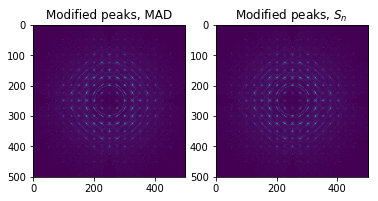

In [30]:
# Show slice of 3D volume in original data and modified data
#plt.subplot(1, 2, 1)
#plt.title('Data without modified peaks')
#plt.imshow(np.nan_to_num(pmn[250])) # Set nans to 0
plt.subplot(1, 2, 1)
plt.title('Modified peaks, MAD')
plt.imshow(pdat[250])
plt.subplot(1, 2, 2)
plt.title('Modified peaks, $S_n$')
plt.imshow(sdat[250])
plt.show()

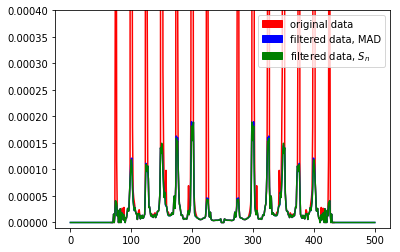

In [31]:
# Plot line through removed bragg peaks in slice of 3d volume
# Also plot same line through original data
# Data is rescaled to show on same vertical axis (intensity is arbitrary)
blue_patch = mpatches.Patch(color = 'blue', label = 'filtered data, MAD')
red_patch = mpatches.Patch(color = 'red', label = 'original data')
green_patch = mpatches.Patch(color = 'green', label = 'filtered data, $S_n$')
plt.legend(handles = [red_patch, blue_patch, green_patch], loc = 1)
plt.plot(pmn[250][250], 'r', pdat[250][250], 'b', sdat[250][250], 'g')
plt.ylim((-0.00001, 0.0004))
plt.show()

C:\Users\6jw\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
C:\Users\6jw\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


Text(0.5,1,'1D slice, 45 degree rotation')

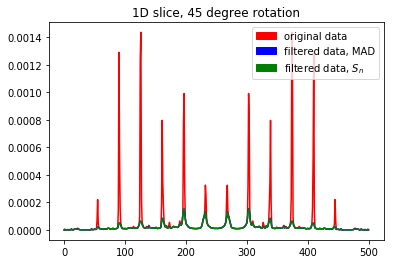

In [32]:
# Rotate 45 degrees to align row with diffuse
# View row 302
# Unfiltered data
a = rotate(pmn[250], 45)[302]
# Filtered data
b = rotate(pdat[250], 45)[302]
c = rotate(sdat[250], 45)[302]

plt.plot(a, 'r', b, 'b', c, 'g')
red_patch = mpatches.Patch(color = 'red', label = 'original data')
blue_patch = mpatches.Patch(color = 'blue', label = 'filtered data, MAD')
green_patch = mpatches.Patch(color = 'green', label = 'filtered data, $S_n$')
plt.legend(handles = [red_patch, blue_patch, green_patch], loc = 1)
plt.title('1D slice, 45 degree rotation')

Text(0.5,1,'1D slice, 45 degree rotation')

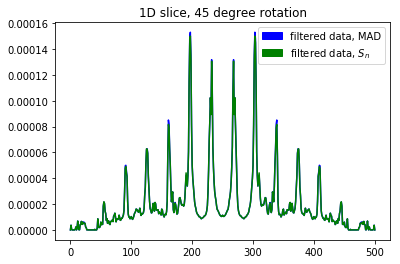

In [33]:
# Same plot as above cell but without unmodified data
plt.plot(b, 'b', c, 'g')
blue_patch = mpatches.Patch(color = 'blue', label = 'filtered data, MAD')
green_patch = mpatches.Patch(color = 'green', label = 'filtered data, $S_n$')
plt.legend(handles = [blue_patch, green_patch], loc = 1)
plt.title('1D slice, 45 degree rotation')

Text(0.5,1,'Absolute difference between MAD and $S_n$ estimator filters')

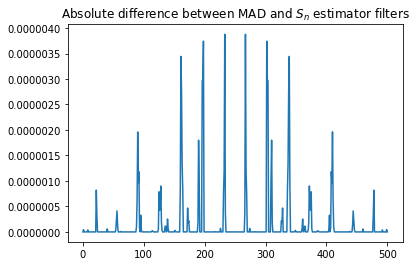

In [38]:
# Plot absolute difference between filters using MAD and S_n estimator 
# Uses 1D slice from previous cell that's aligned along diffuse
plt.plot(np.abs(np.subtract(b, c)))
plt.title('Absolute difference between MAD and $S_n$ estimator filters')

In [26]:
# 3D fourier transform of data 
ft1 = ft_3d(pdat)
ft2 = ft_3d(sdat)

In [35]:
# Generate mask to remove very high intensity peak in center of volume
mask = np.ones((501,501, 501))
mask[248:253, 248:253, 248:253] = 0
# Multiply data set by mask 
ft1 = np.multiply(ft1, mask)
ft2 = np.multiply(ft2, mask)

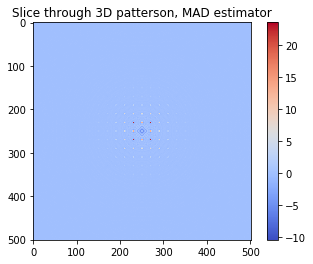

In [39]:
# Show slice through 3D PDF
plt.imshow(np.real(ft1)[250], cmap = 'coolwarm')
plt.title('Slice through 3D patterson, MAD estimator')
plt.colorbar()

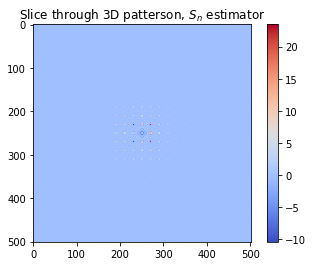

In [40]:
# Show slice through 3D PDF
plt.imshow(np.real(ft2)[250], cmap = 'coolwarm')
plt.title('Slice through 3D patterson, $S_n$ estimator')
plt.colorbar()

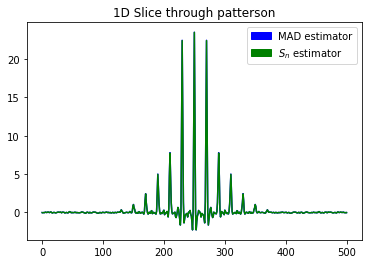

In [41]:
# Plot some 1D line through a slice in the 3D PDF
a = np.real(ft1)[250][270]
b = np.real(ft2)[250][270]
blue_patch = mpatches.Patch(color = 'blue', label = 'MAD estimator')
green_patch = mpatches.Patch(color = 'green', label = '$S_n$ estimator')
plt.legend(handles = [blue_patch, green_patch], loc = 1)
plt.title('1D Slice through patterson')
plt.plot(a, 'b', b, 'g')
plt.show()

Text(0.5,1,'Absolute difference between pattersons using MAD and $S_n$ filters')

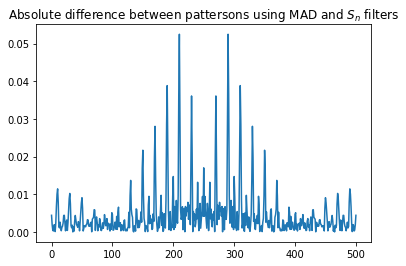

In [51]:
# Plot absolute difference between filters using MAD and S_n estimator 
# Uses 1D slice from previous cell that's aligned along diffuse
plt.plot(np.abs(np.subtract(a, b)))
plt.title('Absolute difference between pattersons using MAD and $S_n$ filters')

(-1, 1)

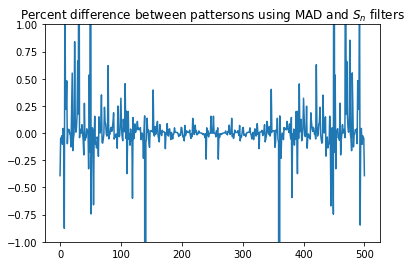

In [49]:
# Plot percent difference between filters using MAD and S_n estimator 
# Uses 1D slice from previous cell that's aligned along diffuse
plt.plot(np.divide(np.abs(np.subtract(a, b)), a))
plt.title('Percent difference between pattersons using MAD and $S_n$ filters')
plt.ylim(-1, 1)